In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit

In [248]:
df = pd.read_csv("../data/parsed_data.csv")
df['radiant_win'] = df['radiant_win'].apply(lambda x: 1 if x==True else  0)
print(df.columns)
for i in range(5,25,5):
    sum_r = 0
    sum_d = 0
    for j in range(1,6):
        sum_r+= df["radiant_position_"+str(j)+"_networth_"+str(i)]
        sum_d+= df["dire_position_"+str(j)+"_networth_"+str(i)]
    df["radiant_networth_"+str(i)] = sum_r
    df["dire_networth_"+str(i)] = sum_d


Index(['match_id', 'game_mode', 'game_duration', 'radiant_score', 'dire_score',
       'average_mmr', 'radiant_win', 'dire_win', 'winner',
       'radiant_position_1_steam_id',
       ...
       'radiant_towers_lost_15', 'dire_towers_lost_15', 'radiant_kills_20',
       'dire_kills_20', 'radiant_win_rate_20', 'dire_win_rate_20',
       'radiant_networth_lead_20', 'dire_networth_lead_20',
       'radiant_towers_lost_20', 'dire_towers_lost_20'],
      dtype='object', length=701)


In [243]:
def generate_columns(include_dire = False, include_rad = True):
    req_columns = ["average_mmr", 'radiant_win']
    for i in range(1, 6):
        req_columns.append("radiant_position_" + str(i) +"_hero" )
        req_columns.append("dire_position_" + str(i) +"_hero" )
        for j in range(5, 25, 5):
            if include_rad:
                req_columns.append("radiant_position_" + str(i) +"_networth_"+str(j))
            if include_dire:
                req_columns.append("dire_position_" + str(i) +"_networth_"+str(j))
    return req_columns

def get_columns_for(team, data_point,range = None,  time=None):
    req_columns = []
    if range:
        for i in range:
            if time:
                req_columns.append(team+"_position_" + str(i) +"_"+data_point+"_"+str(time))
            else:
                req_columns.append(team+"_position_" + str(i) +"_"+data_point)
    else:
        if time:
            return [team+"_"+data_point+"_"+str(time)]
        return [team+"_"+data_point]
    return req_columns


def get_hero_filtered_df(df, num_allowed_heroes):
    dire_heroes_cols = get_columns_for("dire", "hero", range(1,6))
    radiant_heroes_cols = get_columns_for( "radiant", "hero", range(1,6))
    hero_cols = dire_heroes_cols + radiant_heroes_cols
    filtered_df = df
    for col in hero_cols:
        filter_keys = filtered_df[col].value_counts()[:num_allowed_heroes].keys()
        filtered_df = filtered_df.loc[filtered_df[col].isin(filter_keys)]
    return filtered_df

def get_formula_for_heroes_and_networth(include_heroes = True, include_networth=[True, False], networth_time=10):
    formula = ""
    if include_heroes:
        dire_heroes_cols = get_columns_for("dire", "hero", range(1,6))
        radiant_heroes_cols = get_columns_for("radiant", "hero", range(1,6))
        cols = dire_heroes_cols + radiant_heroes_cols
        formula +=  cols[0]
        for col in cols[1:]:
            formula = formula + "+" + col
    if len(include_networth) > 0:
        radiant_networth_cols = get_columns_for("radiant", "networth", range(1,6), networth_time)
        dire_net_cols =  get_columns_for("dire", "networth", range(1,6), networth_time)
        cols = []
        if include_networth[0]:
            cols +=  radiant_networth_cols
        if include_networth[1]:
            cols +=  dire_net_cols
        for col in cols:
            formula = formula + "+" + col
    return formula

def get_formula_for(team, data_point,range=None, time=None):
    formula = ""
    cols = get_columns_for(team, data_point, range, time)
    if len(cols) > 0:
        formula += cols[0]
    else:
        return formula
    for col in cols:
        formula += " + " +col
    return formula

def get_cat_formula_for(team, data_point,range=None, time=None):
    formula = ""
    cols = get_columns_for(team, data_point, range, time)
    if len(cols) > 0:
        formula += cols[0]
    else:
        return formula
    for col in cols:
        formula += " + C(" +col+")"
    return formula

def normalize_cols(df, team, data_point,range=None, time=None):
    cols = get_columns_for(team, data_point, range, time)
    for col in cols:
        df[col]=(df[col]-df[col].mean())/df[col].std()
    return df

def convert_networth_to_ratio(df, team, time):
    cols = get_columns_for(team, "networth", range(1,6), time)
    for col in cols:
        df[col] = df[col]/df[team+"_networth_"+str(time)]
    return df

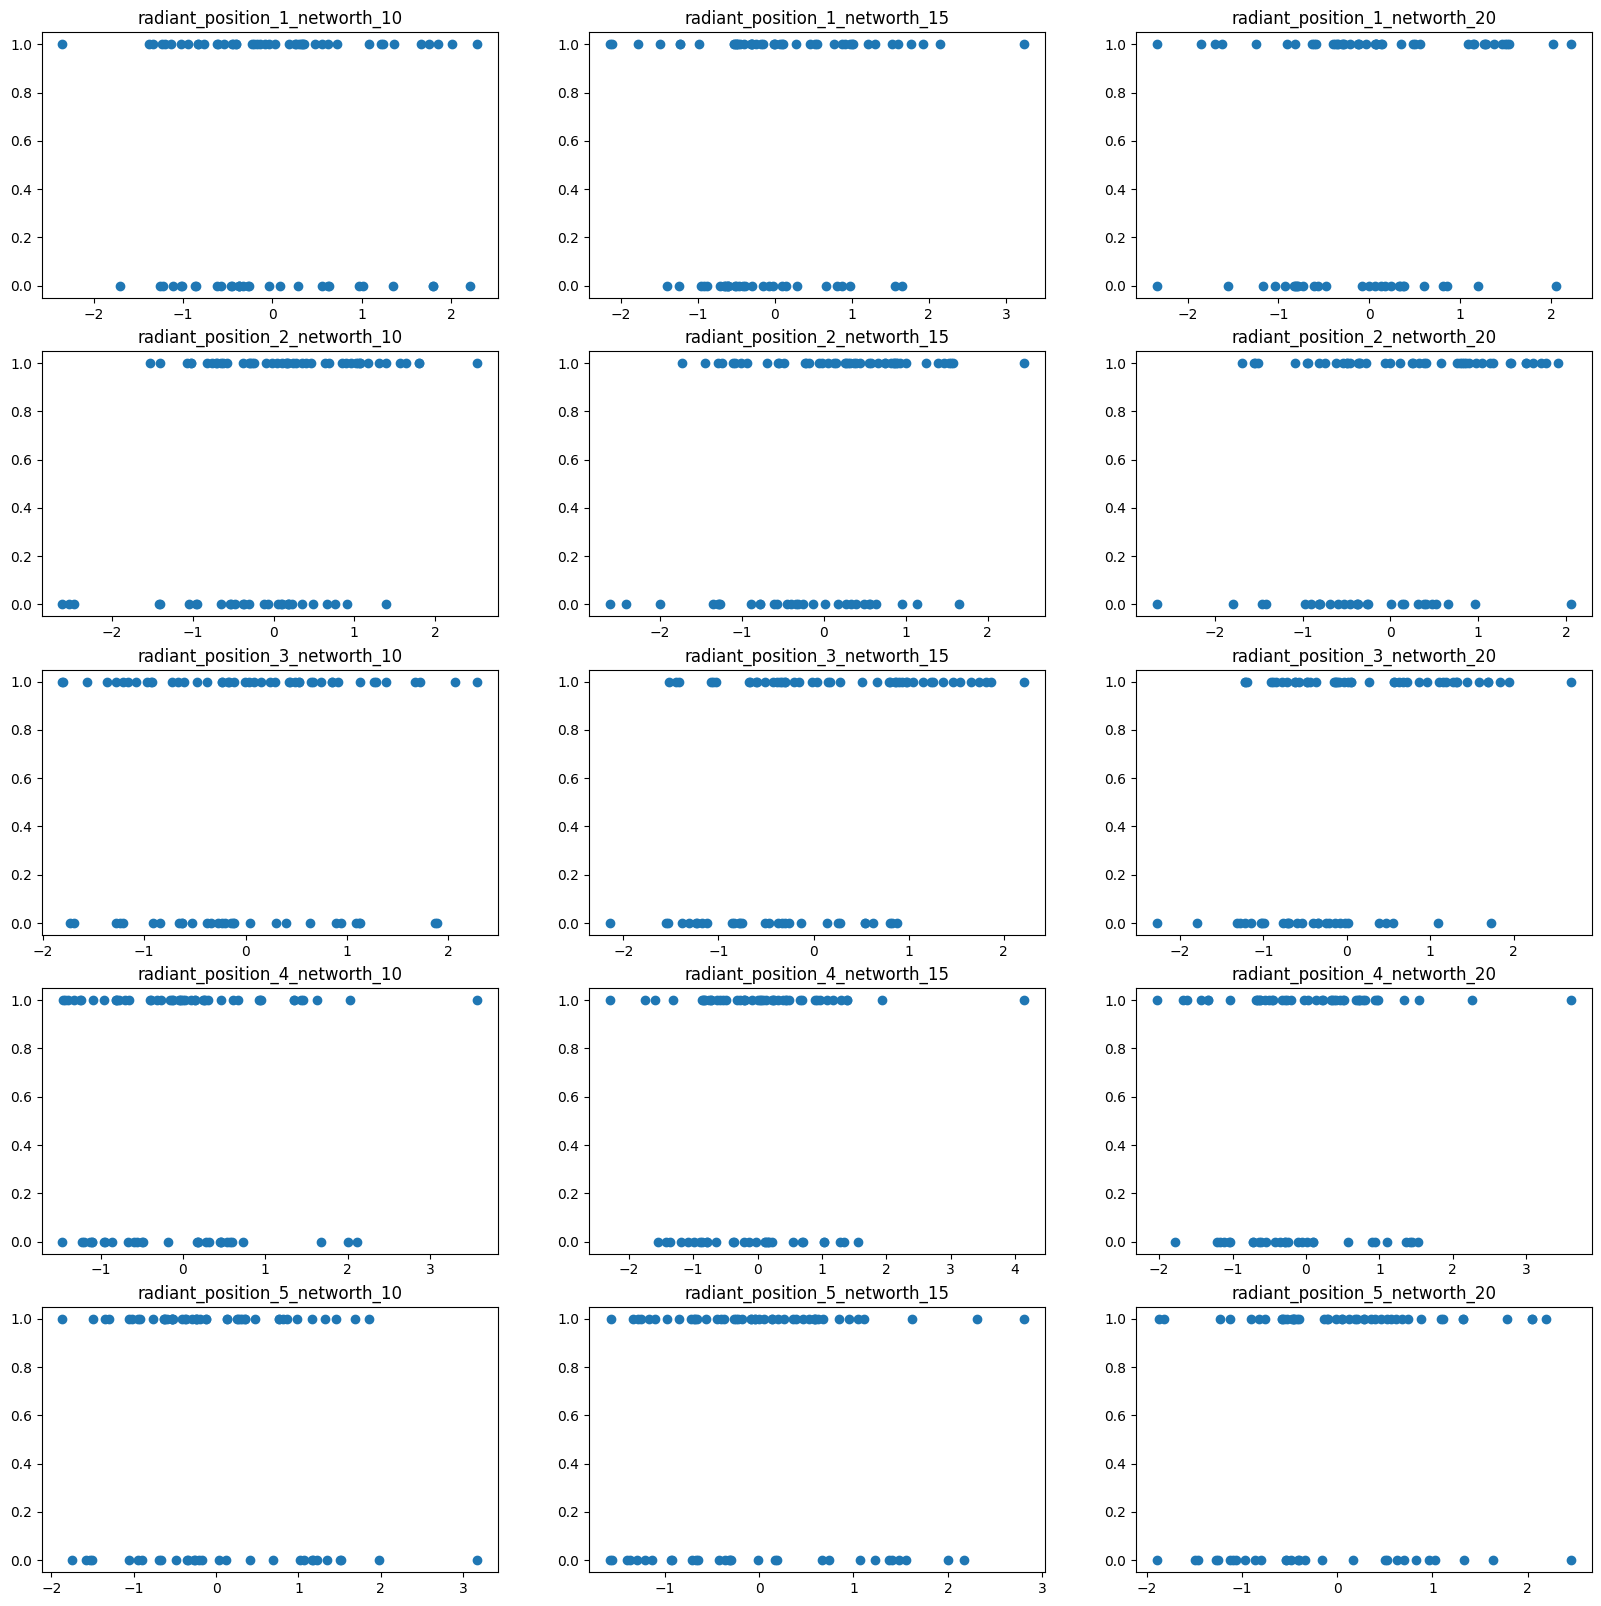

In [165]:
filtered = get_hero_filtered_df(df, 20)

fig, ax = plt.subplots(5,3)
fig.set_figwidth(20)
fig.set_figheight(20)
for i in range(1, 6):
    for j in range(10, 25, 5):
        col = "radiant_position_"+str(i)+"_networth_"+str(j)
        normalized=(filtered[col]-filtered[col].mean())/filtered[col].std()
        ax[i-1][int(j/5)-2].scatter(normalized, filtered["radiant_win"])
        ax[i-1][int(j/5)-2].set_title(col)


In [285]:
test_time = 20
formula = ""
formula += get_formula_for("radiant", "networth", range(1, 6), time=test_time) 
formula += "+"+get_formula_for("dire", "networth", range(1, 6), time=test_time)
#formula += "+"+ get_formula_for("radiant", "networth",time=test_time) 
#formula += "+"+ get_formula_for("dire", "networth",time=test_time) 
#formula += "+"+get_formula_for("radiant", "hero", range(1, 6))
formula += "+"+get_cat_formula_for("dire", "hero", range(1, 6))
formula += "+"+get_cat_formula_for("radiant", "hero", range(1, 6))
#formula += "+"+get_formula_for("radiant", "kills", time=test_time)
#formula += "+"+get_formula_for("dire", "kills", time=test_time)
#formula += "+"+get_formula_for("radiant", "xpm",range(1,6), time=test_time)
#formula += "+"+get_formula_for("dire", "xpm",range(1,6), time=test_time)
#formula +="+"+ get_formula_for("dire", "towers_lost", time=test_time)
#formula += "+"+get_formula_for("radiant", "towers_lost", time=test_time)
normalized_df = get_hero_filtered_df(df, 60)
#normalized_df = convert_networth_to_ratio(filtered, "radiant", test_time)
normalized_df = normalize_cols(normalized_df,"radiant", "networth", time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "networth", time=test_time )
normalized_df = normalize_cols(normalized_df,"radiant","networth", range(1, 6),time=test_time )
normalized_df = normalize_cols(normalized_df,"radiant", "xpm", range(1, 6), time=test_time )
normalized_df = normalize_cols(normalized_df,"radiant", "towers_lost", time=test_time )
normalized_df = normalize_cols(normalized_df,"radiant", "kills", time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "networth",range(1, 6),time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "xpm", range(1, 6), time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "towers_lost", time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "kills", time=test_time )

dota_model = logit(
"radiant_win ~ " + formula,
normalized_df,
).fit()
print(dota_model.summary()) 
marginal = dota_model.get_margeff()
print(marginal.summary())

c:\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35


c:\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix